# XGBoost 로 feature importance 분석하기
- [노션 정리 내용](https://watchstep.notion.site/feature-importance-permutation-importance-79a6e99251fb4fc4a150e8998cbb2534)

- 수행 이유
    - feature importance 를 통해 성능을 개선하기 위함
    - 또한 category와 book_title, author, publisher 와의 관계를 파악하여 imputation 순서를 정하기 위함
    - `가정: category의 importance가 높을 것 같음`
- 수행 방법
    - XGBoost Regressor 모델의 feature importance 파악
    - sklearn의 permutation_importance 사용
    - shap 사용
- 결과 요약
    - language의 importance가 매우 높았는데, 이는 language가 low cardinality feature기 때문
    - language를 feature에서 제거하니 오히려 전체적인 성능이 좋아짐

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import shap
import category_encoders as ce
import xgboost as xgb

In [ ]:
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

## original data 분석하기

In [ ]:
# 경로 지정 후 불러오기 
base_path = os.path.join(os.curdir, 'data')
user_path = os.path.join(base_path, 'users.csv') # original 데이터
book_path = os.path.join(base_path, 'books.csv') # original 데이터
rating_path = os.path.join(base_path, 'train_ratings.csv')

In [ ]:
users = pd.read_csv(user_path, encoding='utf-8')
books = pd.read_csv(book_path, encoding='utf-8')
ratings = pd.read_csv(rating_path, encoding='utf-8')

In [ ]:
# 데이터 merge
merge_ = ratings.merge(books, how='left', on='isbn')
data = merge_.merge(users, how='inner', on='user_id')
print('data shape:', data.shape)

In [ ]:
data.info()

In [ ]:
data.isnull().sum()

In [ ]:
data.dropna(inplace=True)

In [ ]:
data.info()

### 'age'와 다른 columns 간 관계 파악하기

In [ ]:
target = 'age'
y = data[target]
X = data.drop(columns=[target, 'isbn', 'img_url', 'summary', 'img_path', 'language'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
encoder = ce.LeaveOneOutEncoder(return_df=True)
X_train_New = encoder.fit_transform(X_train, y_train)
X_test_New = encoder.transform(X_test)

In [ ]:
model = xgb.XGBRegressor(n_estimators=500, max_depth=5, eta=0.05)
model.fit(X_train_New, y_train)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, model.predict(np.ascontiguousarray(X_test_New))))
rmse

In [ ]:
# Feature importance 
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [ ]:
# Permutation Importance
perm_importance = permutation_importance(model, np.ascontiguousarray(X_test_New), y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance')

In [ ]:
# SHAP Importance
explainer = shap.Explainer(model)
shap_values = explainer(np.ascontiguousarray(X_test_New))
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('SHAP Importance')

## mission data로 분석하기

In [ ]:
base_path = os.path.join(os.curdir, 'data')
merge_path = os.path.join(base_path, 'merge.csv')

In [ ]:
mission_data = pd.read_csv(merge_path, encoding='utf-8')

In [ ]:
mission_data.info()

In [ ]:
mission_data.isna().sum()

In [ ]:
# 필요하지 않은 columns 제거 (이것 저것 제거하면서 파악)
mission_data = mission_data.drop(columns=['img_url', 'summary', 'img_path', 'location', 'age'])
mission_data.info()

In [ ]:
mission_data.dropna(inplace=True)

In [ ]:
mission_data.nunique()

In [ ]:
# target = 'rating' 으로 설정, importance 파악을 위한 변수는 X로 설정
target = 'rating'
y = mission_data[target]
X = mission_data.drop(columns=[target,'age_range','year_of_publication','user_id','book_title', 'category', 'isbn', 'location_city', 'location_state'])

In [ ]:
X.nunique()

In [ ]:
# train, test dataset으로 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
# encoding
encoder = ce.LeaveOneOutEncoder(return_df=True)
X_train_New = encoder.fit_transform(X_train, y_train)
X_test_New = encoder.transform(X_test)

In [ ]:
# XGBoost Regressor 사용 
model = xgb.XGBRegressor(n_estimators=500, max_depth=5, eta=0.05)
model.fit(X_train_New, y_train)
rmse = np.sqrt(mean_squared_error(y_test, model.predict(np.ascontiguousarray(X_test_New))))
rmse

In [ ]:
# feature importance
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [ ]:
# permutation importance
perm_importance = permutation_importance(model, np.ascontiguousarray(X_test_New), y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance')

In [ ]:
# SHAP importance
explainer = shap.Explainer(model)
shap_values = explainer(np.ascontiguousarray(X_test_New))
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('SHAP Importance')

### language 별 rating 시각화
- language에 importance가 몰려있어서, language 별 분석이 필요해 보여서 수행
- seaborn을 사용한 시각화

In [ ]:
mission_data.groupby('language')['rating'].describe().sort_values(by='count', ascending=False)

In [ ]:
# language별 rating (count가 많은 순으로 정렬)
import seaborn as sns
lan_df = mission_data.groupby('language')['rating'].describe().sort_values(by='count', ascending=False)
plt.figure(figsize=(10, 4))
sns.barplot(data=mission_data, x='language', y='rating', order = mission_data['language'].value_counts().index)
plt.show()

In [ ]:
# language별 rating 파악 
sns.lineplot(data=mission_data, x='language', y='rating')
plt.show()

In [ ]:
# language 별 rating 밀도 분포 파악
# 실제 데이터는 1 <= rating <= 10 임을 유의  
plt.figure(figsize=(10, 4))
for lan in mission_data['language'].unique().tolist()[:5]:
    subset = mission_data[mission_data['language']==lan]
    sns.distplot(subset['rating'],
                 hist=False,
                 kde=True,
                 kde_kws={'bw_method': 0.5},
                 label=lan)
plt.title("Distribution of ratings by languages")
plt.legend()
plt.show()

# CatBoost Feature Importance

- 수행 이유
    - CatBoost는 카테고리형 변수가 많은 book crossing data에 맞는 모델이라고 생각
    - feature importance, 특히 shap value를 시각화하고 싶음
- 수행 방법
    - feature 전체에 대해 수행 후, 특정 feature들만 뽑았을 때의 모델 성능 및 feature importance 비교
- 결론
    - CatBoost에서 feature를 다양하게 활용할수록 표현력이 높아지고, 예측 성능이 좋아짐

## 0. 데이터 불러오기

In [1]:
import pandas as pd, numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 
from catboost import *
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import shap
from time import time

In [62]:
users = pd.read_csv('data/users_v2.csv')
books = pd.read_csv('data/books_v6.csv')
train_ratings = pd.read_csv('data/train_ratings.csv')
test_ratings = pd.read_csv('data/test_ratings.csv')

### 기본적인 전처리

train data

In [63]:
merge_ = train_ratings.merge(books, how='left', on='isbn')
data = merge_.merge(users, how='inner', on='user_id')
data.nunique()

user_id                    59803
isbn                      129777
rating                        10
Unnamed: 0                129777
book_title                115473
book_author                52679
year_of_publication           92
publisher                    936
img_url                   129777
language                      24
summary                    69758
img_path                  129777
category                      15
summary_topic                350
category_topic               112
country_publisher_code     13690
location                   13888
age                           91
dtype: int64

In [64]:
# split 되지 않은 location 을 split
data['location_country'] = data['location'].apply(lambda x: x.split(',')[2])

In [65]:
# # 자주 사용되는 merge data (train) 저장
# data.to_csv('data/merge_train.csv', index=False)

In [11]:
print(data.shape)

(306795, 19)


test data

In [53]:
# 순서에 유의하여 merge
test_df = test_ratings.merge(users, on='user_id', how='left').merge(books, on='isbn', how='left')

In [55]:
# split 되지 않은 location 을 split
test_df['location_country'] = test_df['location'].apply(lambda x: x.split(',')[2])

In [56]:
# # 자주 사용되는 merge data (test) 저장
# test_df.to_csv('data/merge_test.csv', index=False)

## 1. Feature Importance 분석 준비

Reference
- [Deep Dive into Catboost Functionalities for Model Interpretation](https://medium.com/towards-data-science/deep-dive-into-catboost-functionalities-for-model-interpretation-7cdef669aeed)
- 위 링크는 CatBoost Classifier

In [13]:
# 오류 수정 필요
def mse(m, X, y): 
    return mean_squared_error(y,m.predict(X))

def permutation_importances(model, X, y, metric):
    baseline = metric(model, X, y)
    imp = []
    for col in X.columns:
        save = X[col].copy()
        X[col] = np.random.permutation(X[col])
        m = metric(model, X, y)
        X[col] = save
        imp.append(m-baseline)
    return np.array(imp)

def baseline_importance(model, X, y, X_test, y_test, metric):
    
    model = CatBoostRegressor(one_hot_max_size = 10, iterations = 500)
    model.fit(X, y, cat_features = categorical_features_indices, verbose = False)
    baseline = metric(model, X_test, y_test)
    
    imp = []
    for col in X.columns:
        
        save = X[col].copy()
        X[col] = np.random.permutation(X[col])
        
        model.fit(X, y, cat_features = categorical_features_indices, verbose = False)
        m = metric(model, X_test, y_test)
        X[col] = save
        imp.append(m-baseline)
    return np.array(imp)


In [15]:
data.nunique()

user_id                    59803
isbn                      129777
rating                        10
Unnamed: 0                129777
book_title                115473
book_author                52679
year_of_publication           92
publisher                    936
img_url                   129777
language                      24
summary                    69758
img_path                  129777
category                      15
summary_topic                350
category_topic               112
country_publisher_code     13690
location                   13888
age                           91
location_country             247
dtype: int64

In [16]:
data = data.drop('Unnamed: 0', axis=1)

In [17]:
data.nunique()

user_id                    59803
isbn                      129777
rating                        10
book_title                115473
book_author                52679
year_of_publication           92
publisher                    936
img_url                   129777
language                      24
summary                    69758
img_path                  129777
category                      15
summary_topic                350
category_topic               112
country_publisher_code     13690
location                   13888
age                           91
location_country             247
dtype: int64

In [18]:
data = data.drop(['user_id', 'isbn', 'book_title', 'img_url', 'summary', 'img_path', 'location'], axis=1)

In [19]:
data.nunique()

rating                       10
book_author               52679
year_of_publication          92
publisher                   936
language                     24
category                     15
summary_topic               350
category_topic              112
country_publisher_code    13690
age                          91
location_country            247
dtype: int64

In [20]:
# # 자주 쓰는 data 저장 
# data.to_csv('data/merge_train_deleted_columns.csv')

In [22]:
# NaN은 원래 float 형 
data = data.fillna('NaN').astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306795 entries, 0 to 306794
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   rating                  306795 non-null  object
 1   book_author             306795 non-null  object
 2   year_of_publication     306795 non-null  object
 3   publisher               306795 non-null  object
 4   language                306795 non-null  object
 5   category                306795 non-null  object
 6   summary_topic           306795 non-null  object
 7   category_topic          306795 non-null  object
 8   country_publisher_code  306795 non-null  object
 9   age                     306795 non-null  object
 10  location_country        306795 non-null  object
dtypes: object(11)
memory usage: 28.1+ MB


In [23]:
# data 분할 
X_train, X_test, y_train, y_test = train_test_split(data.drop("rating", axis = 1), data["rating"], \
                                                    train_size=0.7, random_state=1)

In [24]:
# categorical features index 지정 
categorical_features_indices = [0, 1, 2, 3, 4, 5, 6, 7, 9]

In [26]:
# 확인 
for col in X_train.columns:
    print(col, X_train[col].nunique())

book_author 42701
year_of_publication 90
publisher 921
language 19
category 16
summary_topic 351
category_topic 113
country_publisher_code 11999
age 89
location_country 232


In [27]:
data.isna().sum()

rating                    0
book_author               0
year_of_publication       0
publisher                 0
language                  0
category                  0
summary_topic             0
category_topic            0
country_publisher_code    0
age                       0
location_country          0
dtype: int64

In [28]:
from sklearn.metrics import mean_squared_error

In [29]:
# 각 iteration 에 대한 loss 구하기 
iteration = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]

loss = []
for i in iteration:
    model = CatBoostRegressor(one_hot_max_size = 10, iterations = i)
    model.fit(
        X_train, y_train,
        cat_features = categorical_features_indices,
        verbose = False
    )
    loss.append((i, mean_squared_error(model.predict(X_test), y_test), mean_squared_error(model.predict(X_train), y_train)))
    print(i)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800


<function matplotlib.pyplot.show(close=None, block=None)>

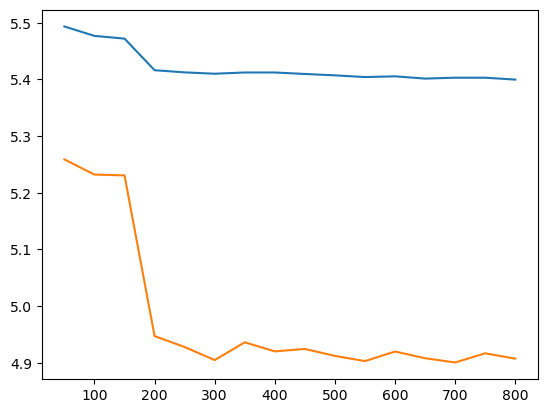

In [30]:
# 실험 1: 대부분의 feature에 대해 학습 
# 실험 2: feature 몇 개 제거 후 학습 -> 성능 훨씬 떨어짐 
plt.plot([i[0] for i in loss],[i[1] for i in loss]) 
plt.plot([i[0] for i in loss],[i[2] for i in loss]) 
plt.show

In [31]:
model = CatBoostRegressor(one_hot_max_size = 10, iterations = 500)
model.fit(
    X_train, y_train,
    cat_features = categorical_features_indices,
    verbose = False
)

## 2. SHAP value 시각화

In [32]:
shap_values = model.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_features_indices), 
                                                                     type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X_test.iloc[3,:])

In [ ]:
# force plot
shap.force_plot(expected_value, shap_values)

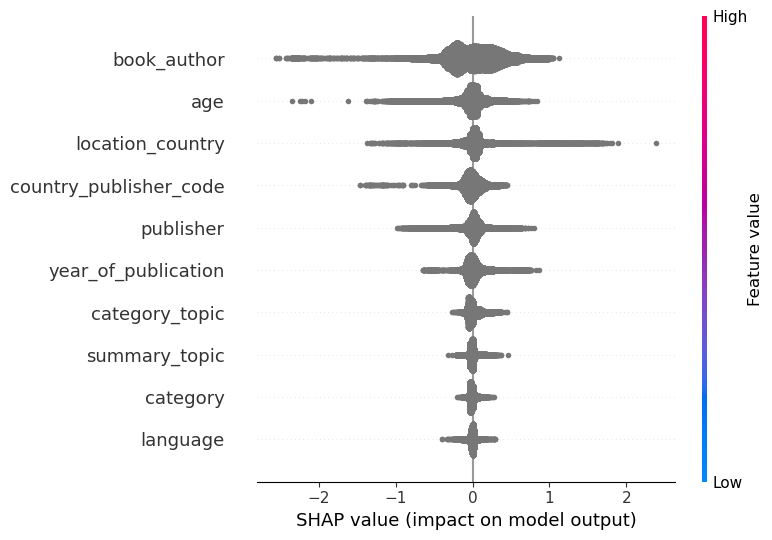

In [33]:
# shap value
import time
start_time = time.time()
shap_values = model.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_features_indices), 
                                                                     type="ShapValues")
shap_values = shap_values[:,:-1]

shap.summary_plot(shap_values, X_test) 
elapsed = time.time() - start_time

In [34]:
elapsed

6.061601638793945

In [35]:
import timeit
timeit.default_timer()

3343484.641560365

In [38]:
# feature importance plot 함수 정의 
def get_feature_imp_plot(method):
    
    if method == "Permutation":
        fi =  permutation_importances(model, X_test, y_test, mse)
    
    elif method == "Baseline":
        fi = baseline_importance(model, X_train, y_train, X_test, y_test, mse)
    
    elif method == "ShapeValues":
        shap_values = model.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_features_indices), 
                                                                     type="ShapValues")
        shap_values = shap_values[:,:-1]
        shap.summary_plot(shap_values, X_test) 
        
    else:
        fi = model.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_features_indices), 
                                                                     type=method)
        
    if method != "ShapeValues":
        feature_score = pd.DataFrame(list(zip(X_test.dtypes.index, fi )),
                                        columns=['Feature','Score'])

        feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

        plt.rcParams["figure.figsize"] = (12,7)
        ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
        ax.set_title("Feature Importance using {}".format(method), fontsize = 14)
        ax.set_xlabel("features")
        plt.show()

In [ ]:
# 예측값 변화를 통한 feature importance 파악 
# 오류 발생 
%time get_feature_imp_plot(y_test, method="PredictionValuesChange")

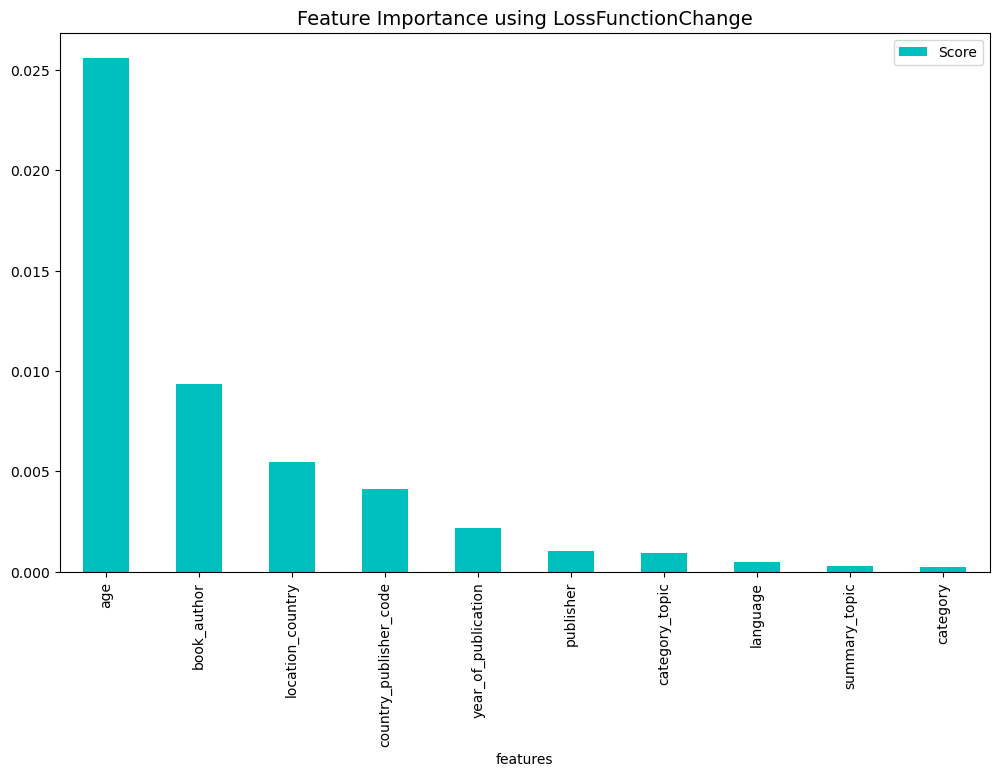

CPU times: user 12.4 s, sys: 800 ms, total: 13.2 s
Wall time: 2.92 s


In [40]:
# loss function 변화를 통한 feature importance 파악 
%time get_feature_imp_plot(method="LossFunctionChange")

In [ ]:
# permutation 변화 feature importance
# 오류 발생
%time get_feature_imp_plot(method="Permutation")

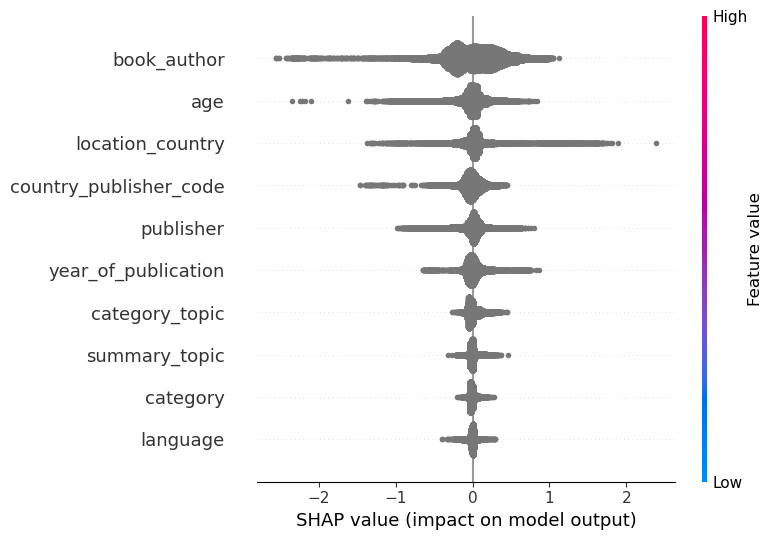

CPU times: user 16.2 s, sys: 2.78 s, total: 18.9 s
Wall time: 6.08 s


In [41]:
# shap value
# 색깔이 없는건 모두 카테고리형으로 봤기 때문 (추후 age, year_of_publication은 연속형으로 변경)
%time get_feature_imp_plot(method="ShapeValues")

In [ ]:
# baseline에 따른 feature importance
# 오류 발생
%time get_feature_imp_plot(method="Baseline")

## 3. Interaction Feature Importance

- feature 조합의 importance 파악

In [44]:
fi = model.get_feature_importance(Pool(X_test, label=y_test,
                                       cat_features=categorical_features_indices), 
                                    type="Interaction")

In [45]:
fi[:5]

array([[0.        , 8.        , 4.5999566 ],
       [0.        , 7.        , 4.5343037 ],
       [1.        , 2.        , 4.05568267],
       [0.        , 9.        , 3.78965939],
       [0.        , 1.        , 3.62693417]])

In [46]:
fi_new = []
for k,item in enumerate(fi):  
    first = X_test.dtypes.index[fi[k][0]]
    second = X_test.dtypes.index[fi[k][1]]
    if first != second:
        fi_new.append([first + "_" + second, fi[k][2]])

In [47]:
# top5 interaction feature importance 확인 
fi_new[:5]

[['book_author_age', 4.599956596815965],
 ['book_author_country_publisher_code', 4.53430370186214],
 ['year_of_publication_publisher', 4.055682672604697],
 ['book_author_location_country', 3.789659391076335],
 ['book_author_year_of_publication', 3.626934171780294]]

In [48]:
# feature 조합과 score 저장 
feature_score = pd.DataFrame(fi_new,columns=['Feature-Pair','Score'])

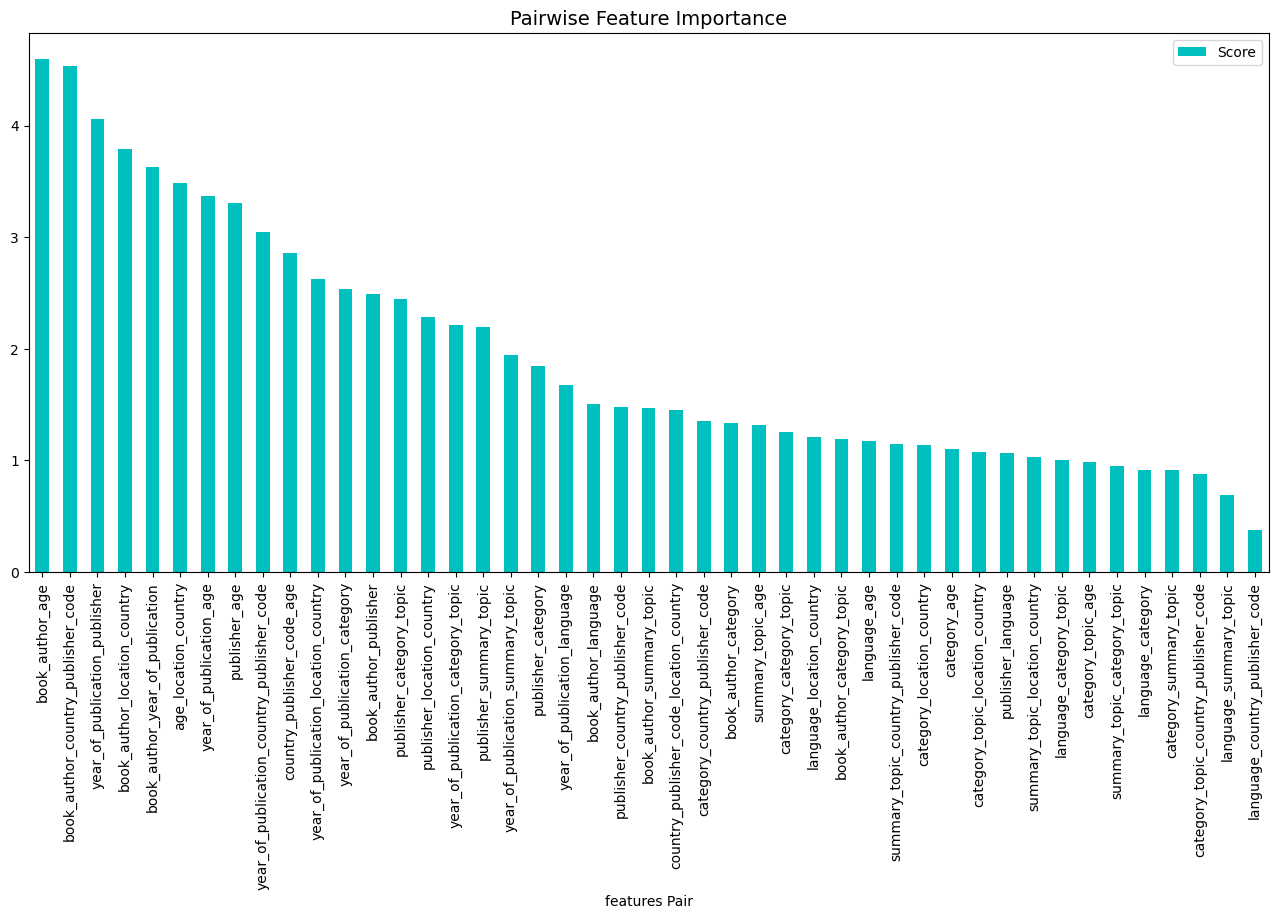

In [49]:
# pairwise feature importance 시각화 
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
plt.rcParams["figure.figsize"] = (16,7)
ax = feature_score.plot('Feature-Pair', 'Score', kind='bar', color='c')
ax.set_title("Pairwise Feature Importance", fontsize = 14)
ax.set_xlabel("features Pair")
plt.show()